# Evaluate HNN family (HNN, DGNet) for 'experiment-2body' problem

- Original HNN from hamiltonian-nn by Sam Greydanus

- Original DGNet from discrete-autograd by Takashi Matsubara

- modified and adapted by Jae Hoon (Daniel) Lee

In [1]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_default_dtype(torch.float32)
import argparse
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

EXPERIMENT_DIR = './experiment-2body'
sys.path.append(EXPERIMENT_DIR)

from data import random_config, get_orbit

In [2]:
TRIALS = 5 * 3
T_SPAN = 50
T_POINTS = 2000

HNN2_PTH = 'hnn2_2body.pth'
DGNET_PTH = 'dgnet_2body.pth'

In [3]:
def load_model_weights(model, filepath, device='cpu'):
    if not os.path.exists(filepath):
        print(f"Error: file not found: {filepath}")
        return

    try:
        state_dict = torch.load(filepath, map_location=torch.device(device))
        model.load_state_dict(state_dict)
        model.to(device)

        print(f"Model's weight has successfully been loaded: {filepath} (Device: {device})")
    
    except Exception as e:
        print(f"Error occurred while loading the model: {e}")

In [4]:
def is_jupyter():
    return 'ipykernel' in sys.modules

## DGNet

In [5]:
import dgnet

In [6]:
def get_dgnet_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--noretry', dest='noretry', action='store_true', help='not do a finished trial.')
    # network, experiments
    parser.add_argument('--input_dim', default=2 * 4, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=200, type=int, help='batch_size')
    parser.add_argument('--nonlinearity', default='tanh', type=str, help='neural net nonlinearity')
    parser.add_argument('--total_steps', default=10000, type=int, help='number of gradient steps')
    parser.add_argument('--input_noise', default=0.0, type=int, help='std of noise added to inputs')
    # display
    parser.add_argument('--print_every', default=200, type=int, help='number of gradient steps between prints')
    parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
    parser.add_argument('--name', default='2body', type=str, help='only one option right now')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--save_dir', default=EXPERIMENT_DIR, type=str, help='where to save the trained model')
    # model
    parser.add_argument('--model', default='hnn', type=str, help='used model.')
    parser.add_argument('--solver', default='dg', type=str, help='used solver.')
    parser.add_argument('--friction', default=False, action="store_true", help='use friction parameter')
    parser.set_defaults(feature=True)

    if is_jupyter():
        return parser.parse_args([]) 
    else:
        return parser.parse_args()

In [7]:
def get_dgnet_model(device='cpu'):

    args = get_dgnet_args()
    model = dgnet.DGNet(args.input_dim, args.hidden_dim,
                        nonlinearity=args.nonlinearity, friction=args.friction, model=args.model, solver=args.solver)
    model = model.to(device)
    return model

## HNN2

(Hamiltonian Neural Network: modified version to GPU support: named as HNN2)

In [8]:
def get_hnn2_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--input_dim', default=2*4, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=200, type=int, help='batch_size')
    parser.add_argument('--input_noise', default=0.0, type=int, help='std of noise added to inputs')
    parser.add_argument('--nonlinearity', default='tanh', type=str, help='neural net nonlinearity')
    parser.add_argument('--total_steps', default=10000, type=int, help='number of gradient steps')
    parser.add_argument('--print_every', default=200, type=int, help='number of gradient steps between prints')
    parser.add_argument('--name', default='2body', type=str, help='only one option right now')
    parser.add_argument('--baseline', dest='baseline', action='store_true', help='run baseline or experiment?')
    parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--save_dir', default=EXPERIMENT_DIR, type=str, help='where to save the trained model')
    parser.set_defaults(feature=True)

    if is_jupyter():
        return parser.parse_args([]) 
    else:
        return parser.parse_args()

In [9]:
class HNN2(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN2, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.assume_canonical_coords = assume_canonical_coords
        self.field_type = field_type

        # --- modification 1 for GPU support: register_buffer is used ---
        # self.M = self.permutation_tensor(input_dim) # original HNN code by Sam Greydanus
        M_tensor = self.permutation_tensor(input_dim)
        self.register_buffer('M_buffer', M_tensor) # register M tensor as buffer
        
    def forward(self, x):
        # traditional forward pass
        if self.baseline:
            return self.differentiable_model(x)

        y = self.differentiable_model(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        return y.split(1,1)

    '''def rk4_time_derivative(self, x, dt):
        # need to be modified to support GPU in rk4 or to use torchdiffeq
        return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)'''

    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F1, F2 = self.forward(x) # traditional forward pass

        # --- modification 2 for GPU support: use x's device when creating tensors ---
        conservative_field = torch.zeros_like(x, device=x.device) # device=x.device
        solenoidal_field = torch.zeros_like(x, device=x.device) # device=x.device

        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0] # gradients for conservative field
            # create eye on the same device where self.M_buffer lives
            eye = torch.eye(*self.M_buffer.shape, device=self.M_buffer.device)
            conservative_field = dF1 @ eye

        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
            # self.M_buffer is used
            solenoidal_field = dF2 @ self.M_buffer.t()

        if separate_fields:
            return [conservative_field, solenoidal_field]

        return conservative_field + solenoidal_field

    def permutation_tensor(self, n):
        # returns a torch tensor and processed at __init__
        M = None
        if self.assume_canonical_coords:
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            M = torch.ones(n,n)
            M *= 1 - torch.eye(n)
            M[::2] *= -1
            M[:,::2] *= -1
            for i in range(n):
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M

In [10]:
def get_hnn2_model(device):
    from hamiltonian_nn.nn_models import MLP
    args = get_hnn2_args()
    output_dim = 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    # The modified HNN class above (HNN2: GPU version) is used.
    model = HNN2(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type) 
    model.to(device) 
    return model

## Comparison between HNN and DGNet perfomances

In [11]:
def load_model(model, filename, dir_path=None):
    if dir_path == None:
       dir_path = EXPERIMENT_DIR + "/weights"
    file_path = os.path.join(dir_path, filename)
    load_model_weights(model, file_path, 'cpu')

def load_models(hnn_pth=HNN2_PTH, dgnet_pth=DGNET_PTH):
    '''
    We use HNN2 for Hamilton NN because we trained HNN2, 
    which is HNN modified for GPU support,
    in the same GPU context as DGNet
    '''
    hnn_model = get_hnn2_model('cpu')
    dgnet_model = get_dgnet_model('cpu')
    load_model(hnn_model, filename=hnn_pth)
    load_model(dgnet_model, filename=dgnet_pth)   
    return hnn_model, dgnet_model

In [12]:
hnn_model, dgnet_model=load_models()

Model's weight has successfully been loaded: ./experiment-2body/weights/hnn2_2body.pth (Device: cpu)
Model's weight has successfully been loaded: ./experiment-2body/weights/dgnet_2body.pth (Device: cpu)


In [13]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,2).T
    return deriv.reshape(-1)

In [14]:
def compute_orbits(hnn_model, dgnet_model, t_span=T_SPAN, t_points=T_POINTS, trials=TRIALS):   
    t_span = [0, t_span]
    length = 2000
    t_points = length
    
    stats = {}
    true_orbits, hnn_orbits, dgnet_orbits = [], [], []
    for trial_ix in range(trials):
        np.random.seed(trial_ix)
        state = random_config()

        # true orbit
        orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)
        true_orbits.append(orbit)

        # hnn orbit
        torch.set_grad_enabled(True)  # When executing HNN, set to True.
        update_fn_2 = lambda t, y0: model_update(t, y0, hnn_model)
        hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn_2)
        hnn_orbits.append(hnn_orbit)

        # dgnet orbit
        torch.set_grad_enabled(False)  # When executing DGNet, set to False.
        mass = state[:, :1]
        x0 = state[:, 1:].T.reshape(-1)
        dgnet_orbit = dgnet_model.get_orbit(x0, t_eval=np.linspace(t_span[0], t_span[1], t_points))
        dgnet_orbit = dgnet_orbit.reshape(dgnet_orbit.shape[0], 4, 2)
        dgnet_orbit = np.concatenate([np.ones((dgnet_orbit.shape[0], 1, 2)), dgnet_orbit], axis=1)
        dgnet_orbit = dgnet_orbit.transpose(2, 1, 0)
        dgnet_orbits.append(dgnet_orbit)

    
    stats['true_orbits'] = np.stack(true_orbits)
    stats['hnn_orbits'] = np.stack(hnn_orbits)
    stats['dgnet_orbits'] = np.stack(dgnet_orbits)
    
    return stats


In [15]:
stats = compute_orbits(hnn_model, dgnet_model)

/media/danieljh/shared/Code/piml-comp-git/assess-hamiltonian-nn-family/dgnet/modules.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x1 = fsolve(wrapped_func, to_numpy(x0), *args, **kwargs)


/media/danieljh/shared/Code/piml-comp-git/assess-hamiltonian-nn-family/dgnet/modules.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x1 = fsolve(wrapped_func, to_numpy(x0), *args, **kwargs)


In [16]:
def save_plot_as_png(fig, title, tag=None, experiment_dir='./experiment-2body'):
    save_dir = os.path.join(experiment_dir, 'comparison')
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")
        
    filename = f"{title.replace(' ', '_')}.png"
    if tag is not None:
        filename = tag + "_" + filename
    save_path = os.path.join(save_dir, filename)
    
    fig.savefig(save_path, bbox_inches='tight', dpi=150)
    print(f"Plot saved to: {save_path}")

In [17]:
def get_xy_data_from_orbits(orbit_data_array):
    """
    For the given orbit list, extracts and returns all x, y coordinates.
    데이터 형태: (N_bodies, 5, N_steps)
    """
    # 0th-index indicates N_bodies (2)
    # 1st-index indicates [t, x, y, vx, vy] (5)
    # 2nd-index indicates N_steps (500)
    # x coord: index 1
    # y coord: index 2

    # Fetching x(index 1), y(index 2) from 3-dim array, flattens them.
    all_x = orbit_data_array[:, 1, :].flatten()
    all_y = orbit_data_array[:, 2, :].flatten()
    
    return all_x, all_y


def get_xy_plot_limit(true_orbit, hnn_orbit, dgnet_orbit):
    # Get x, y coord of all dataset.
    tx, ty = get_xy_data_from_orbits(true_orbit)
    hx, hy = get_xy_data_from_orbits(hnn_orbit)
    dx, dy = get_xy_data_from_orbits(dgnet_orbit)

    all_x_data = np.concatenate([tx, hx, dx])
    all_y_data = np.concatenate([ty, hy, dy])

    x_min, x_max = all_x_data.min(), all_x_data.max()
    y_min, y_max = all_y_data.min(), all_y_data.max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    
    max_range = max(x_range, y_range)

    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    
    padding = 0.05 * max_range
    half_range_with_pad = (max_range / 2) + padding

    x_lim = [x_mid - half_range_with_pad, x_mid + half_range_with_pad]
    y_lim = [y_mid - half_range_with_pad, y_mid + half_range_with_pad]

    return x_lim, y_lim

In [18]:
def plot_one_orbit(stats, orbit_id=0, t_span=50, t_points=2000, tag=None):
    from data import potential_energy, kinetic_energy, total_energy
    
    true_orbit = stats['true_orbits'][orbit_id]
    hnn_orbit = stats['hnn_orbits'][orbit_id]
    dgnet_orbit = stats['dgnet_orbits'][orbit_id]

    print('true_orbit[', orbit_id,']: ', true_orbit.shape)
    print('hnn_orbit[', orbit_id,']: ', hnn_orbit.shape)
    print('dgnet_orbit[', orbit_id,']: ', dgnet_orbit.shape)

    t_eval = np.linspace(0, t_span, t_points)
      
    lw=1
    fs=7
    ts=15
    tpad = 7
    ls=12
    ms=40
    
    ## Orbits
    x_lim, y_lim = get_xy_plot_limit(true_orbit, hnn_orbit, dgnet_orbit)

    ## Energies
    real_pe, real_ke, real_etot = potential_energy(true_orbit), kinetic_energy(true_orbit), total_energy(true_orbit)
    hnn_pe, hnn_ke, hnn_etot = potential_energy(hnn_orbit), kinetic_energy(hnn_orbit), total_energy(hnn_orbit)
    dgnet_pe, dgnet_ke, dgnet_etot = potential_energy(dgnet_orbit), kinetic_energy(dgnet_orbit), total_energy(dgnet_orbit)

    emax = np.min([real_pe.min(), real_ke.min(), real_etot.min(),
                    hnn_pe.min(), hnn_ke.min(), hnn_etot.min(),
                    dgnet_pe.min(), dgnet_ke.min(), dgnet_etot.min()])

    emin = np.max([real_pe.max(), real_ke.max(), real_etot.max(),
                    hnn_pe.max(), hnn_ke.max(), hnn_etot.max(),
                    dgnet_pe.max(), dgnet_ke.max(), dgnet_etot.max()])
    pad = 0.1 * (emax - emin)
    emax += pad
    emin -= pad

    fig = plt.figure(figsize=[7,7], dpi=100)
    plt.subplot(2,2,1)
    plt.title('Trajectories (HNN)', fontsize=ts, pad=tpad)
    colors = ['orange', 'purple']
    for i, path in enumerate(true_orbit):
        plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
        x0, y0 = path[1][0], path[2][0]
        x1, y1 = path[1][1], path[2][1]
        plt.scatter(x0, y0, color=colors[i], edgecolors='black', s=70, zorder=5)
        dx = x1 - x0
        dy = y1 - y0
        plt.quiver(x0, y0, dx, dy, color='black', angles='xy', scale_units='xy', 
                   scale=0.015, width=0.01, zorder=6, pivot='tail')

    colors = [(1,0,0), (1, 0.6, 0.6)]
    for i, path in enumerate(hnn_orbit):
        plt.plot(path[1], path[2], '--', c=colors[i], label='HNN path, body {}'.format(i), linewidth=2)
    
    #plt.axis('equal')
    plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
    plt.legend(fontsize=fs)
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    
    plt.subplot(2,2,2)
    plt.title('Trajectories (DGNet)', fontsize=ts, pad=tpad)
    colors = ['orange', 'purple']
    for i, path in enumerate(true_orbit):
        plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
        x0, y0 = path[1][0], path[2][0]
        x1, y1 = path[1][1], path[2][1]
        plt.scatter(x0, y0, color=colors[i], edgecolors='black', s=70, zorder=5)
        dx = x1 - x0
        dy = y1 - y0
        plt.quiver(x0, y0, dx, dy, color='black', angles='xy', scale_units='xy', 
                   scale=0.015, width=0.01, zorder=6, pivot='tail')

    colors = [(1,0,0), (1, 0.6, 0.6)]
    for i, path in enumerate(dgnet_orbit):
        plt.plot(path[1], path[2], '--', c=colors[i], label='DGNet path, body {}'.format(i), linewidth=2)
    
    #plt.axis('equal')
    plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
    plt.legend(fontsize=fs)
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)

    plt.subplot(2,2,3) 

    plt.title('Energy(u)', fontsize=ts, pad=tpad)
    
    plt.plot(t_eval, real_pe, color='g', linestyle=':', label='Pot.El(True_u)', linewidth=lw)
    plt.plot(t_eval, real_ke, color='c', linestyle='-.', label='Kin.E(True_u)', linewidth=lw)
    plt.plot(t_eval, real_etot, color='k', linestyle='-', label='Tot.E(True_u)', linewidth=lw)

    plt.plot(t_eval, hnn_pe, color='red', linestyle=':', label='Pot.E(HNN_u)', linewidth=lw)
    plt.plot(t_eval, hnn_ke, color='coral', linestyle='-.', label='Kin.E(HNN_u)', linewidth=lw)
    plt.plot(t_eval, hnn_etot, color='darkred', linestyle='-', label='Tot(HNN_u)', linewidth=lw)
    
    plt.legend(ncol=2, mode="expand", borderaxespad=0., bbox_to_anchor=(0.11, 0.4, 0.8, .102), loc='center', fontsize=fs)

    plt.xlabel('Time')
    plt.ylabel('Energy')
    
    plt.xlim(0, t_span)
    plt.ylim(emin, emax)

    plt.subplot(2,2,4) 

    plt.title('Energy(u)', fontsize=ts, pad=tpad)

    plt.plot(t_eval, real_pe, color='g', linestyle=':', label='Pot.E(True_u)', linewidth=lw)
    plt.plot(t_eval, real_ke, color='c', linestyle='-.', label='Kin.E(True_u)', linewidth=lw)
    plt.plot(t_eval, real_etot, color='k', linestyle='-', label='Tot.E(True_u)', linewidth=lw)

    plt.plot(t_eval, dgnet_pe, color='red', linestyle=':', label='Pot.E(DGNet_u)', linewidth=lw)
    plt.plot(t_eval, dgnet_ke, color='coral', linestyle='-.', label='Kin.E(DGNet_u)', linewidth=lw)
    plt.plot(t_eval, dgnet_etot, color='darkred', linestyle='-', label='Tot.E(DGNet_u)', linewidth=lw)

    plt.legend(ncol=2, mode="expand", borderaxespad=0., bbox_to_anchor=(0.11, 0.4, 0.8, .102), loc='center', fontsize=fs)

    plt.xlabel('Time')
    plt.ylabel('Energy')

    plt.xlim(0, t_span)
    plt.ylim(emin, emax)

    plt.tight_layout() ; plt.show()
    
    title='2body-orbit_' + str(orbit_id)
    save_plot_as_png(fig, title, tag=tag)

true_orbit[ 0 ]:  (2, 5, 2000)
hnn_orbit[ 0 ]:  (2, 5, 2000)
dgnet_orbit[ 0 ]:  (2, 5, 2000)


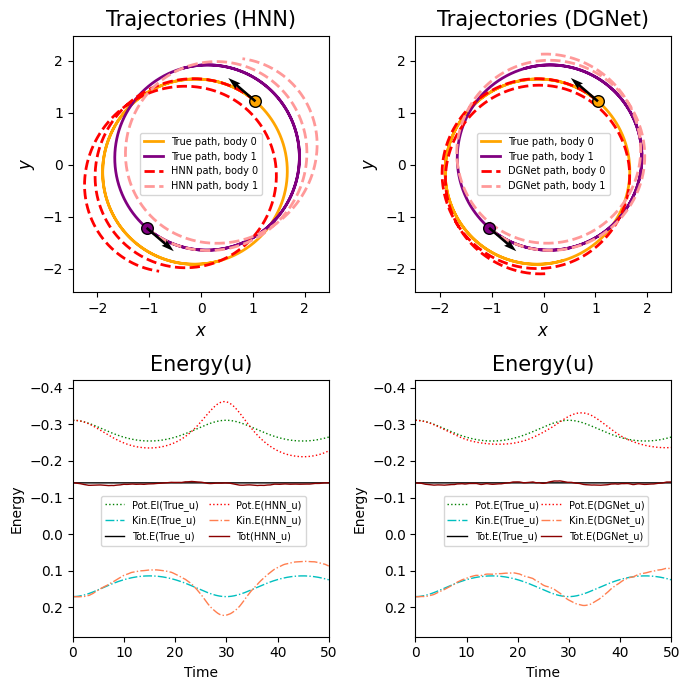

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_0.png
true_orbit[ 1 ]:  (2, 5, 2000)
hnn_orbit[ 1 ]:  (2, 5, 2000)
dgnet_orbit[ 1 ]:  (2, 5, 2000)


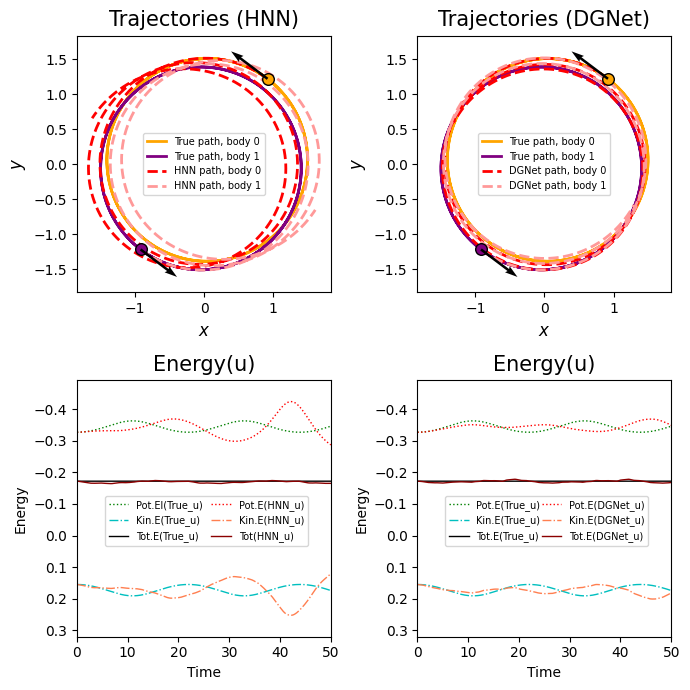

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_1.png
true_orbit[ 2 ]:  (2, 5, 2000)
hnn_orbit[ 2 ]:  (2, 5, 2000)
dgnet_orbit[ 2 ]:  (2, 5, 2000)


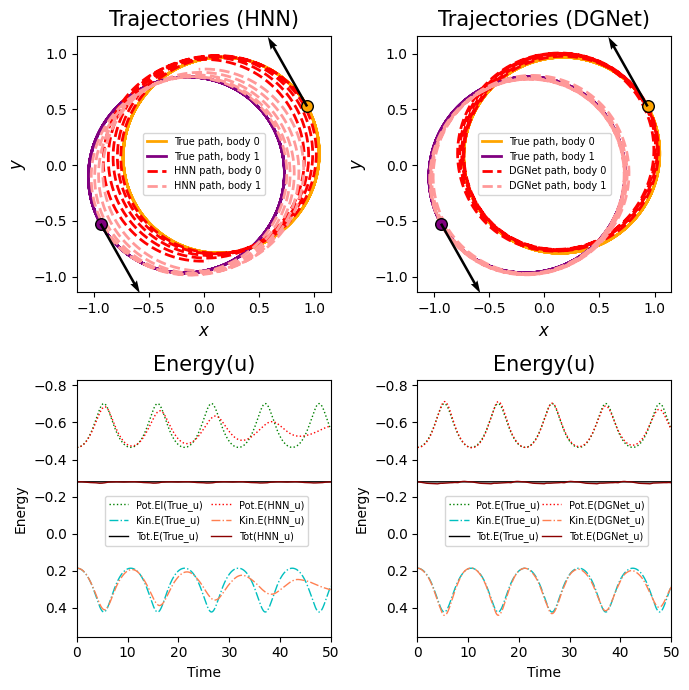

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_2.png
true_orbit[ 3 ]:  (2, 5, 2000)
hnn_orbit[ 3 ]:  (2, 5, 2000)
dgnet_orbit[ 3 ]:  (2, 5, 2000)


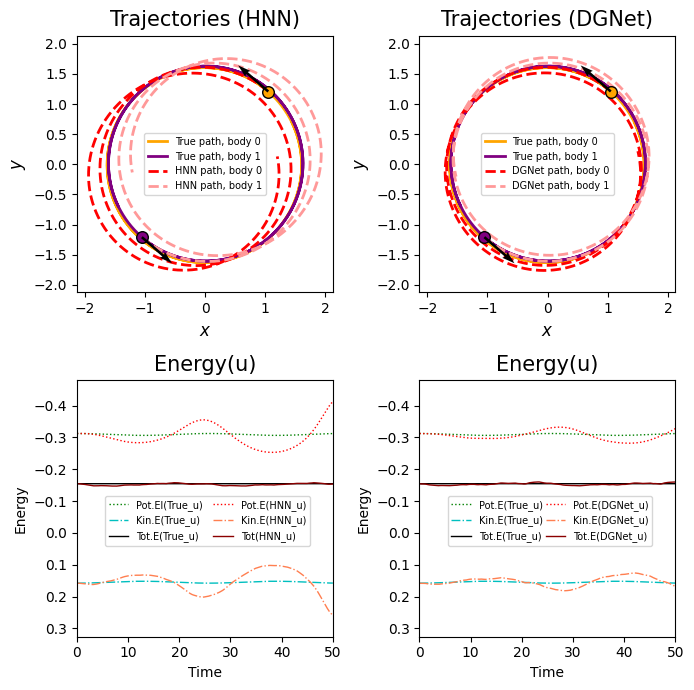

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_3.png
true_orbit[ 4 ]:  (2, 5, 2000)
hnn_orbit[ 4 ]:  (2, 5, 2000)
dgnet_orbit[ 4 ]:  (2, 5, 2000)


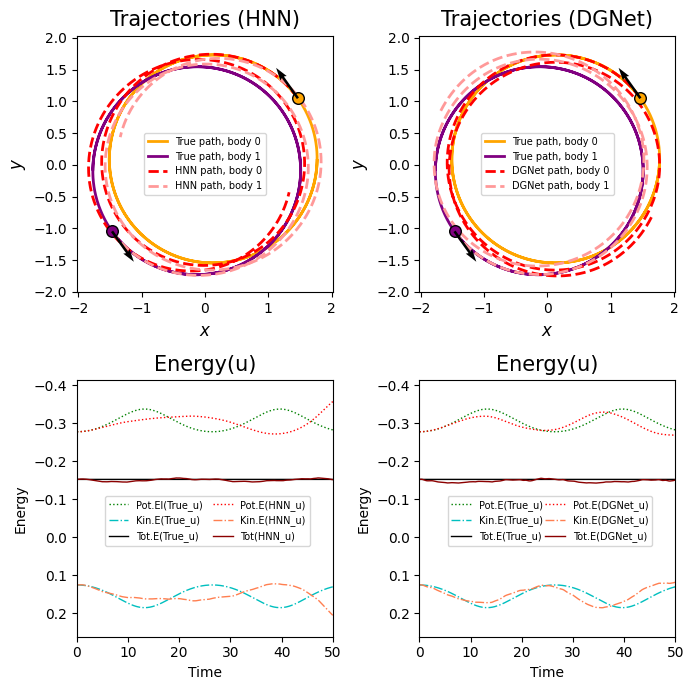

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_4.png
true_orbit[ 5 ]:  (2, 5, 2000)
hnn_orbit[ 5 ]:  (2, 5, 2000)
dgnet_orbit[ 5 ]:  (2, 5, 2000)


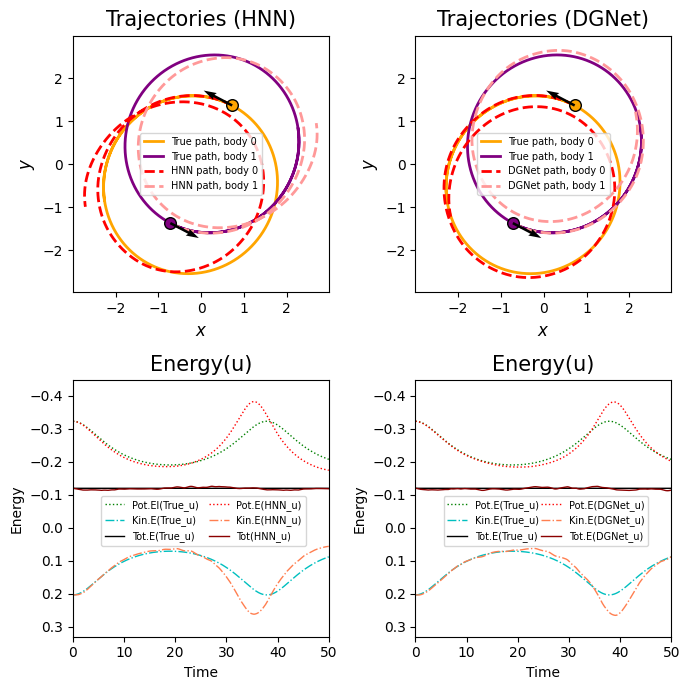

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_5.png
true_orbit[ 6 ]:  (2, 5, 2000)
hnn_orbit[ 6 ]:  (2, 5, 2000)
dgnet_orbit[ 6 ]:  (2, 5, 2000)


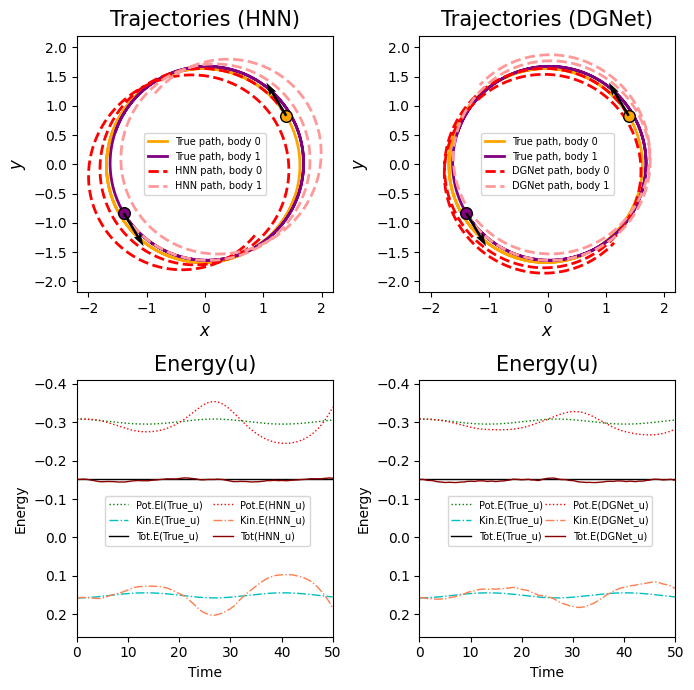

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_6.png
true_orbit[ 7 ]:  (2, 5, 2000)
hnn_orbit[ 7 ]:  (2, 5, 2000)
dgnet_orbit[ 7 ]:  (2, 5, 2000)


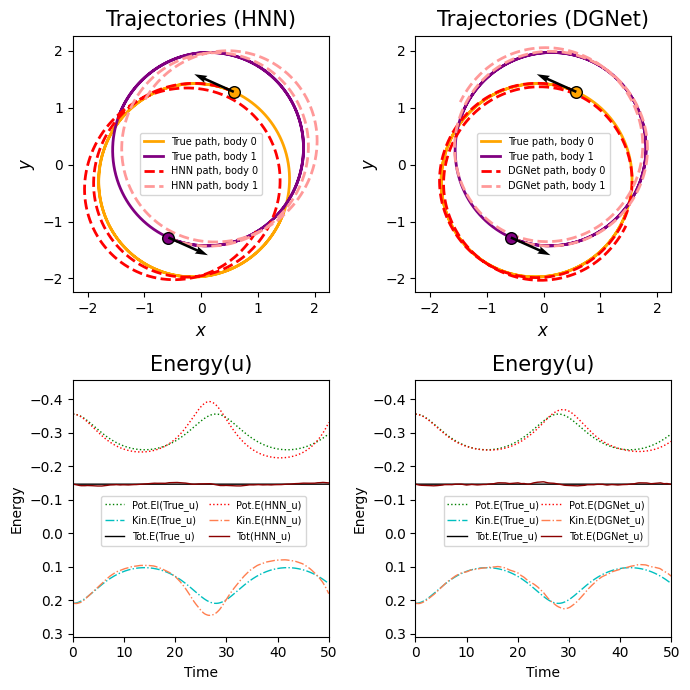

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_7.png
true_orbit[ 8 ]:  (2, 5, 2000)
hnn_orbit[ 8 ]:  (2, 5, 2000)
dgnet_orbit[ 8 ]:  (2, 5, 2000)


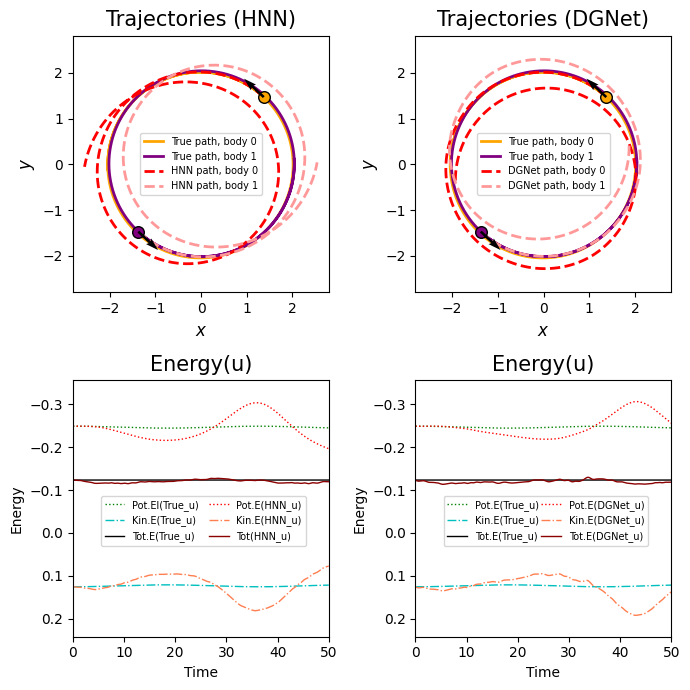

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_8.png
true_orbit[ 9 ]:  (2, 5, 2000)
hnn_orbit[ 9 ]:  (2, 5, 2000)
dgnet_orbit[ 9 ]:  (2, 5, 2000)


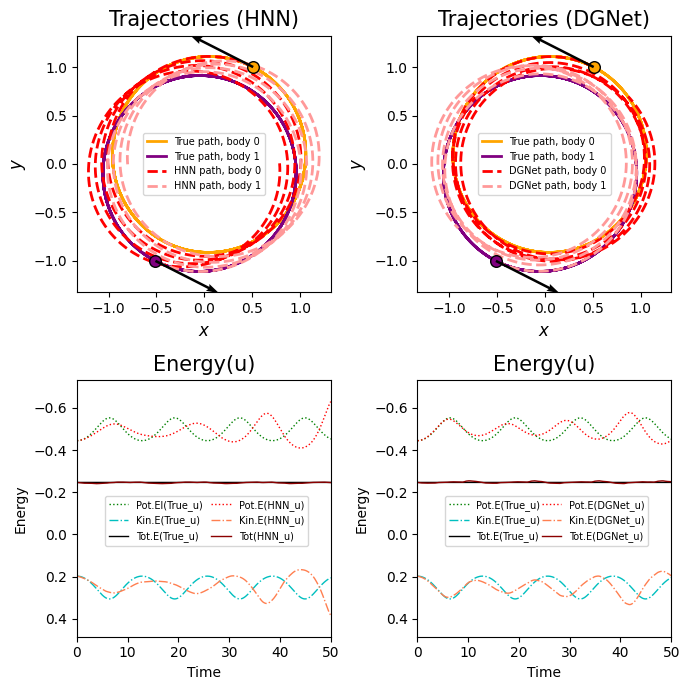

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_9.png
true_orbit[ 10 ]:  (2, 5, 2000)
hnn_orbit[ 10 ]:  (2, 5, 2000)
dgnet_orbit[ 10 ]:  (2, 5, 2000)


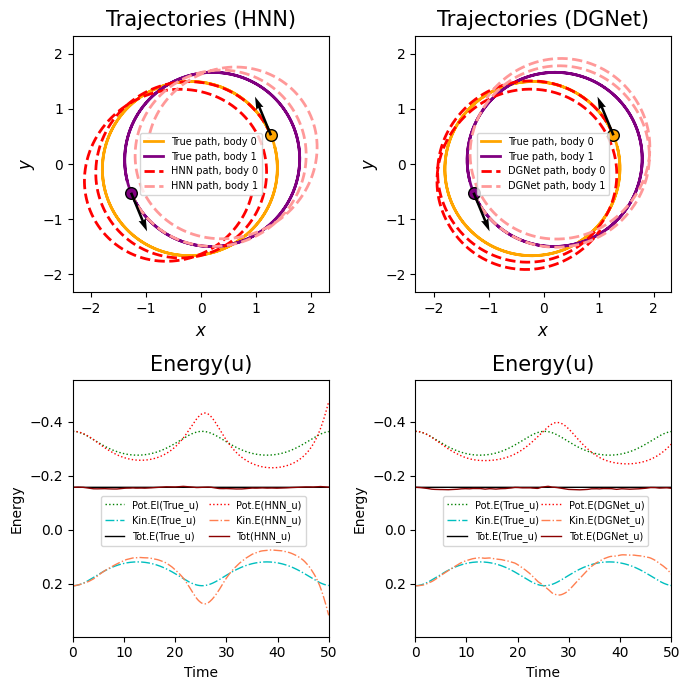

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_10.png
true_orbit[ 11 ]:  (2, 5, 2000)
hnn_orbit[ 11 ]:  (2, 5, 2000)
dgnet_orbit[ 11 ]:  (2, 5, 2000)


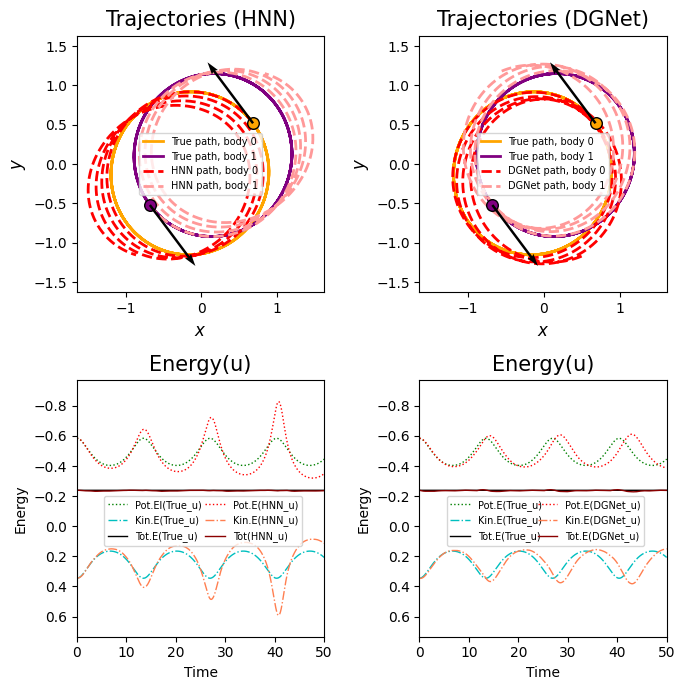

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_11.png
true_orbit[ 12 ]:  (2, 5, 2000)
hnn_orbit[ 12 ]:  (2, 5, 2000)
dgnet_orbit[ 12 ]:  (2, 5, 2000)


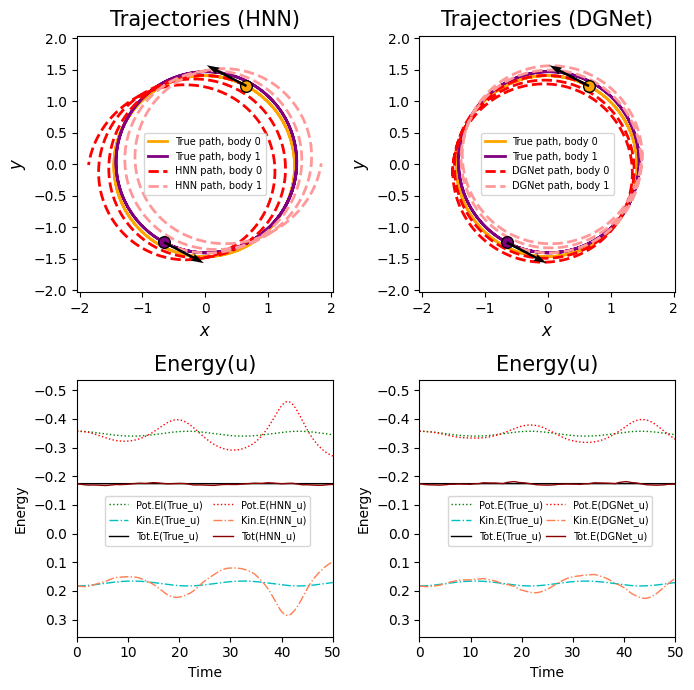

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_12.png
true_orbit[ 13 ]:  (2, 5, 2000)
hnn_orbit[ 13 ]:  (2, 5, 2000)
dgnet_orbit[ 13 ]:  (2, 5, 2000)


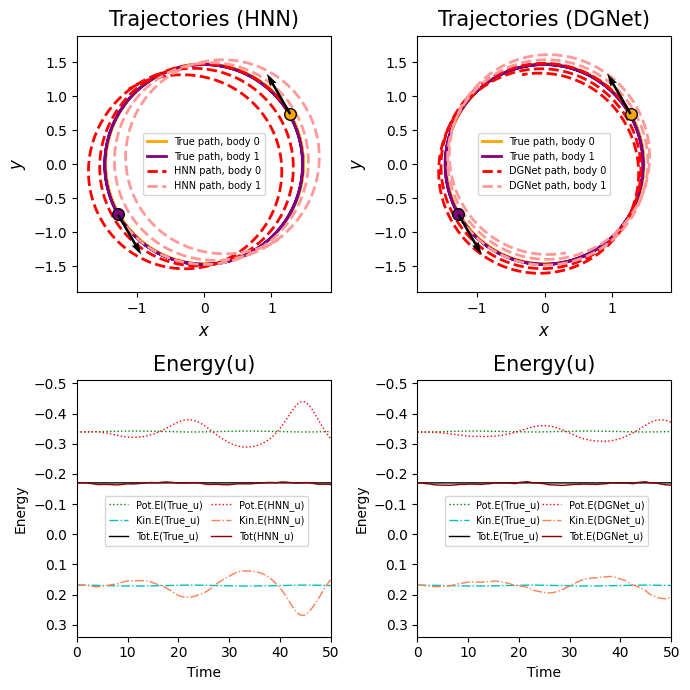

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_13.png
true_orbit[ 14 ]:  (2, 5, 2000)
hnn_orbit[ 14 ]:  (2, 5, 2000)
dgnet_orbit[ 14 ]:  (2, 5, 2000)


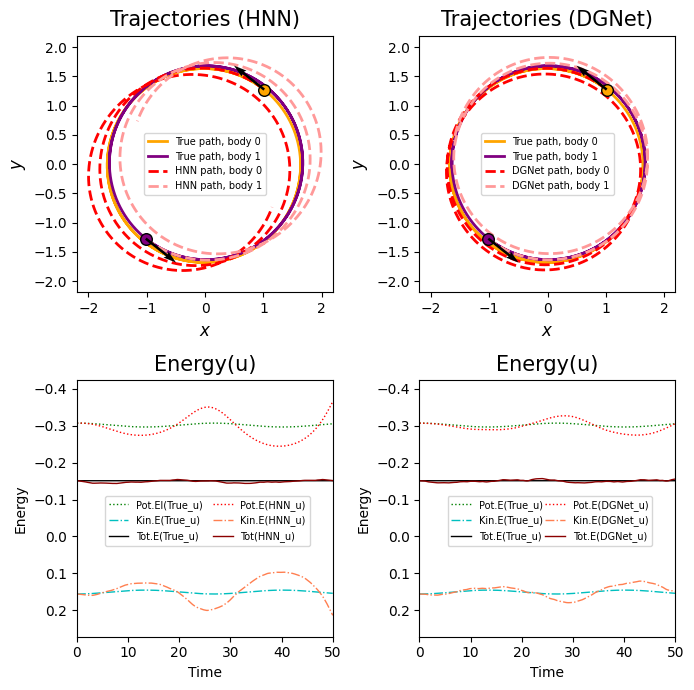

Plot saved to: ./experiment-2body/comparison/hnn_vs_dgnet_2body-orbit_14.png


In [19]:
num_orbits = stats['true_orbits'].shape[0]
for i in range(num_orbits):
    plot_one_orbit(stats, i, tag="hnn_vs_dgnet")